"ヒルシュ" (Hirushu) refers to Hirschsprung's disease

"卵子" (Ranshi) means "egg cell"

In [ ]:
from scipy import sparse
from scipy.sparse import linalg
from pathlib import Path
from numpy.linalg import norm
from scipy.sparse import csc_matrix
from scipy.sparse import spdiags
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing
from pandas import Series,DataFrame
from IPython.display import clear_output

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sn
import scipy.sparse.linalg as spla
import time, os, glob
import numpy as np
np.set_console_logoptions(threshold=np.inf)
import librosa, librosa.display
import csv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
# setup for current dir
current_dir = os.getcwd() + '/Tamura/引き継ぎ/ヒルシュ'
current_dir

raman_raw_dir = current_dir + '/raman_raw'
hirsch_dir = {}
normal_dir = {}
other_dir = {}
for l in os.listdir(raman_raw_dir):
    if "hirsch" in l:
        hirsch_dir[l] = raman_raw_dir + '/' + l
        continue

    if "normal" in l:
        normal_dir[l] = raman_raw_dir + '/' + l
        continue
    
    other_dir[l] = raman_raw_dir + '/' + l



In [ ]:
def load_raman_data_txt(directory_path) -> pd.DataFrame:
    """
    Load all .txt Raman data files from a directory into a pandas DataFrame.
    
    Parameters:
    -----------
    directory_path : str
        Path to the directory containing Raman data files
        
    Returns:
    --------
    DataFrame with columns:
        - wavenumber: The Raman shift in cm^-1
        - Multiple columns for each sample's intensity values
    """
    # Check if directory exists
    if not os.path.exists(directory_path):
        console_log(f"Directory {directory_path} does not exist")
        raise FileNotFoundError(f"Directory {directory_path} does not exist")
    
    # Find all txt files in the directory
    file_paths = glob.glob(os.path.join(directory_path, "*.txt"))
    
    if not file_paths:
        console_log(f"No .txt files found in {directory_path}")
        raise ValueError(f"No .txt files found in {directory_path}")
    
    # Create a dictionary to store all dataframes
    data_dict = {}
    wavenumbers = None
    
    # Process each file
    for file_path in file_paths:
        # Get the filename without extension for column naming
        file_name = os.path.basename(file_path).split('.')[0]
        
        # Load data from the file
        df = pd.read_csv(file_path, sep=',', header=None, names=['wavenumber', file_name])
        
        # If this is our first file, save the wavenumbers
        if wavenumbers is None:
            wavenumbers = df['wavenumber'].values
            data_dict['wavenumber'] = wavenumbers
        
        # Store the intensity values
        data_dict[file_name] = df[file_name].values
    
    # Create a combined dataframe
    combined_df = pd.DataFrame(data_dict)
    
    console_log(f"Loaded {len(file_paths)} Raman spectra files")
    return combined_df

def visualize_raman_spectra(df, title="Raman Spectra", figsize=(12, 6), 
                           xlim=None, ylim=None, legend=True, 
                           legend_loc='best', sample_limit=10) -> plt:
    """
    Visualize the Raman spectra data.
    Clears any existing plots before creating a new one.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing Raman data with wavenumber column and intensity columns
    title : str
        Plot title
    figsize : tuple
        Figure size (width, height) in inches
    xlim : tuple or None
        Optional x-axis limits (min, max)
    ylim : tuple or None
        Optional y-axis limits (min, max)
    legend : bool
        Whether to display the legend
    legend_loc : str
        Legend location
    sample_limit : int
        Maximum number of samples to plot (to avoid overcrowding)
    """
    # Clear any existing plots
    plt.clf()
    plt.close('all')
    
    # Create a figure with a specific ID to reuse
    fig = plt.figure(num=1, figsize=figsize, clear=True)
    
    # Get column names except 'wavenumber'
    intensity_columns = [col for col in df.columns if col != 'wavenumber']
    
    # Limit number of samples to plot if needed
    if len(intensity_columns) > sample_limit:
        console_log(f"Limiting plot to {sample_limit} samples out of {len(intensity_columns)}")
        intensity_columns = intensity_columns[:sample_limit]
    
    # Plot each spectrum
    for col in intensity_columns:
        plt.plot(df['wavenumber'], df[col], label=col)
    
    # Set plot attributes
    plt.title(title)
    plt.xlabel('Raman Shift (cm⁻¹)')
    plt.ylabel('Intensity')
    plt.grid(True, alpha=0.3)
    
    if legend:
        plt.legend(loc=legend_loc, fontsize='small')
    
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    
    plt.tight_layout()
    return plt

def load_raman_data_csv(csv_filepath) -> pd.DataFrame:
    """
    Load Raman spectral data from a CSV file into a pandas DataFrame.
    
    Parameters:
    -----------
    csv_filepath : str
        Path to the CSV file containing Raman spectral data
        
    Returns:
    --------
    DataFrame with columns:
        - wavenumber: The Raman shift in cm^-1
        - Multiple columns for each sample's intensity values
    """
    # Check if file exists
    if not os.path.exists(csv_filepath):
        console_log(f"File {csv_filepath} does not exist")
        raise FileNotFoundError(f"File {csv_filepath} does not exist")
    
    # Load data
    try:
        # Read CSV file - header is in row 0
        df = pd.read_csv(csv_filepath, header=0)
        
        # Set the first column as the wavenumber column
        wavenumber_col = df.columns[0]
        df = df.rename(columns={wavenumber_col: 'wavenumber'})
        
        # Check if data has expected structure
        if len(df.columns) < 2:
            raise ValueError(f"CSV file {csv_filepath} does not contain enough columns")
        
        console_log(f"Loaded Raman spectra with {len(df.columns)-1} samples and {len(df)} data points")
        return df
        
    except Exception as e:
        console_log(f"Error loading CSV file: {e}")
        raise
    
def add_gaussian_noise(spectrum: pd.DataFrame, noise_level=0.01) -> pd.DataFrame:
    noisy_df = spectrum.copy()
    # Add noise only to numeric columns except 'wavenumber'
    for col in noisy_df.columns:
        if col != 'wavenumber' and np.issubdtype(noisy_df[col].dtype, np.number):
            noise = np.random.normal(loc=0.0, scale=noise_level, size=noisy_df[col].shape)
            noisy_df[col] = noisy_df[col] + noise
    return noisy_df

def normalize_spectrum(spectrum: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize the intensity values of the Raman spectrum.
    
    Parameters:
    -----------
    spectrum : pandas DataFrame
        DataFrame containing Raman data with wavenumber column and intensity columns
        
    Returns:
    --------
    DataFrame with normalized intensity values
    """
    # Create a copy to avoid modifying the original DataFrame
    normalized_df = spectrum.copy()
    
    # Normalize all columns except 'wavenumber'
    for col in normalized_df.columns:
        if col != 'wavenumber':
            normalized_df[col] = (normalized_df[col] - normalized_df[col].min()) / (normalized_df[col].max() - normalized_df[col].min())
    
    return normalized_df

def auto_detect_baseline_region(df, window_size=50):
    """
    Automatically detect flat (low-variance) region in the Raman spectrum.
    Uses a sliding window over the wavenumber axis.
    """
    wavenumber = df['wavenumber'].values
    spectra = df.drop('wavenumber', axis=1).values

    min_std = np.inf
    min_idx = 0
    
    # Scan through the spectrum using a moving window
    for i in range(0, len(wavenumber) - window_size):
        segment = spectra[i:i+window_size, :]
        segment_std = np.std(segment)
        
        if segment_std < min_std:
            min_std = segment_std
            min_idx = i
    
    # Extract the best baseline region
    start_wn = wavenumber[min_idx]
    end_wn = wavenumber[min_idx + window_size - 1]
    
    console_log(f"Auto-detected baseline region: {start_wn:.2f}–{end_wn:.2f} cm⁻¹")

    # Return the sliced baseline DataFrame
    baseline_df = df[(df['wavenumber'] >= start_wn) & (df['wavenumber'] <= end_wn)]
    return baseline_df



In [ ]:
continue_loop = True
checklen = 1
check_dir = normal_dir
for key, value in check_dir.items():
    if not continue_loop or checklen > len(check_dir):
        break
    # Load the data
    console_log(f"\nProcessing {key}...")
    raman_df = load_raman_data_txt(check_dir[key])
    
    # Clear previous output
    clear_output(wait=True)
    
    # console_log current processing info again after clearing
    console_log(f"\n[{checklen}/{len(check_dir)}] Processing {key}...")
    console_log(f"Loaded {len(raman_df.columns)-1} spectra")
    
    # Visualize the data (reuses the same figure)
    visualize_raman_spectra(raman_df, title=key, 
                           figsize=(14, 8), legend_loc='upper right', sample_limit=20)
    plt.show()  # This will show the plot in the current cell
    
    user_input = input("Press Enter to continue or type 'q' to quit: ")
    if user_input.lower() == 'q':
        continue_loop = False
    checklen += 1

Loaded Raman spectra with 20 samples and 858 data points
1100.0581 1787.8837
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Baseline noise std calculated: 34.4779


<module 'matplotlib.pyplot' from '/home/zerozed/ai-env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

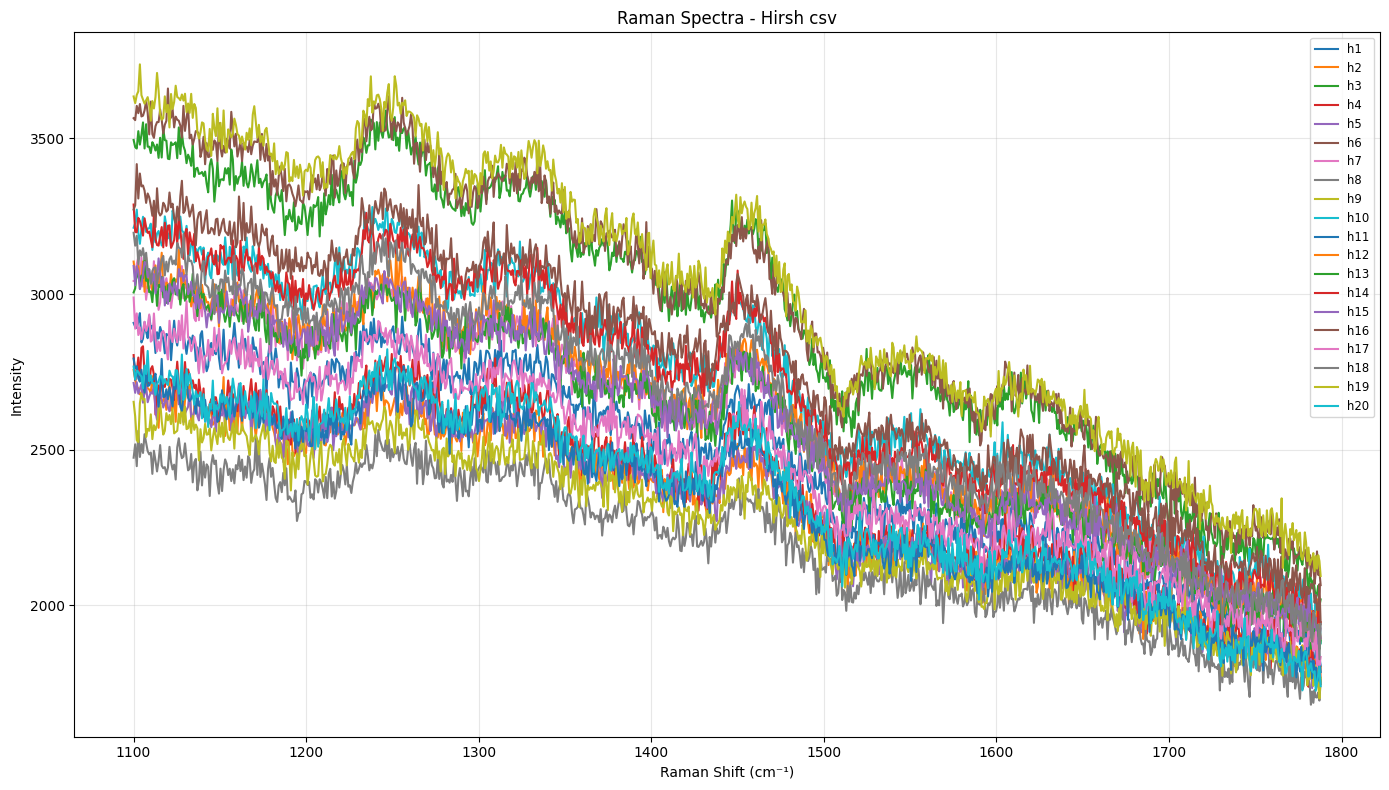

In [31]:
rawdata_dir = os.path.join(current_dir, 'データ', 'merged_data_raw', 'Case2', 'hirsch', 'hirsch.csv')
raman_df = load_raman_data_csv(rawdata_dir)
# Visualize the data (reuses the same figure)
# Check wavenumber range
console_log(raman_df['wavenumber'].min(), raman_df['wavenumber'].max())
baseline_df = auto_detect_baseline_region(raman_df, window_size=50)
noise_std = baseline_df.drop('wavenumber', axis=1).std().mean()
console_log(f"Baseline noise std calculated: {noise_std:.4f}")
raman_df = add_gaussian_noise(raman_df, noise_level=noise_std)
visualize_raman_spectra(raman_df, title="Raman Spectra - Hirsh csv",
                        figsize=(14, 8), legend_loc='upper right', sample_limit=20)

/mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/Tamura/引き継ぎ/ヒルシュ/データ/merged_data_raw/Case2/hirsch/hirsch.csv


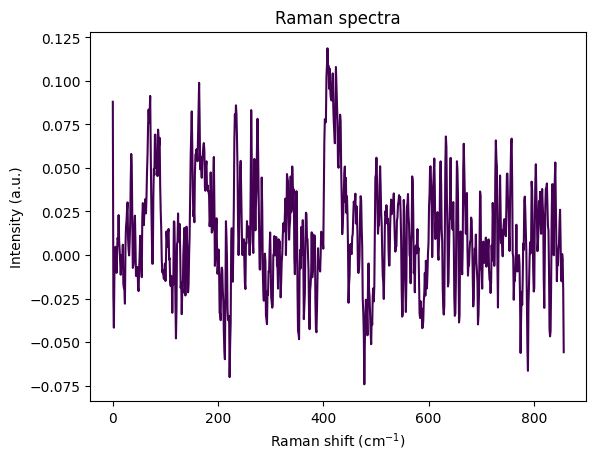

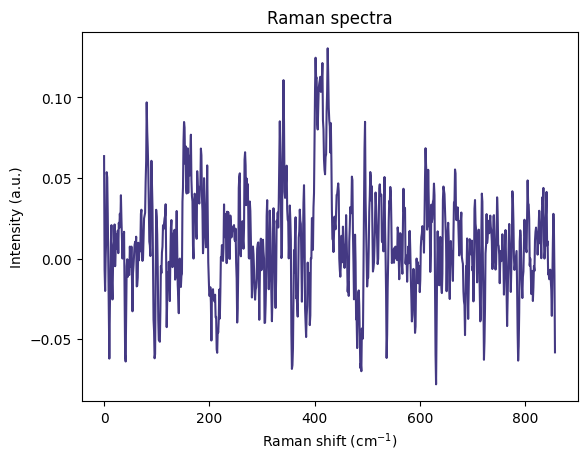

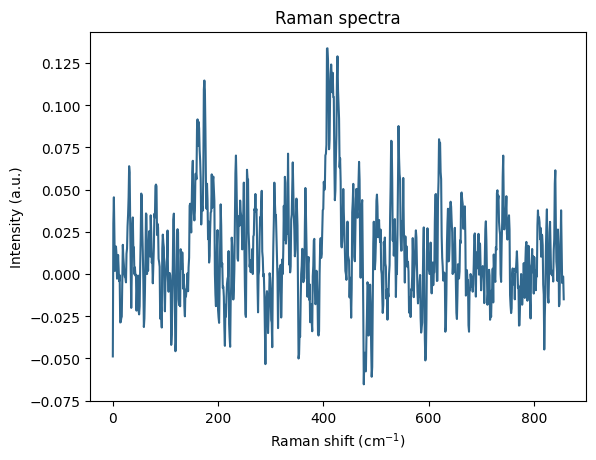

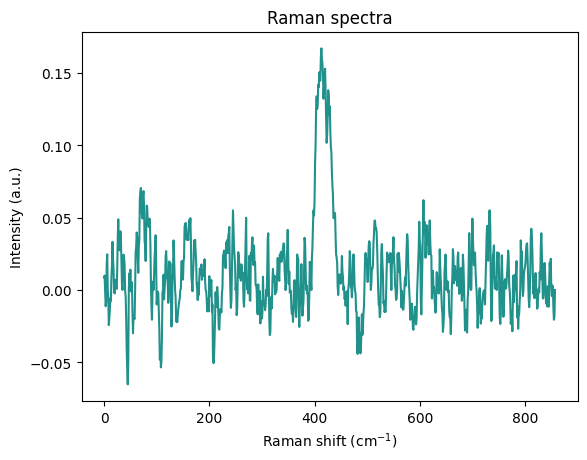

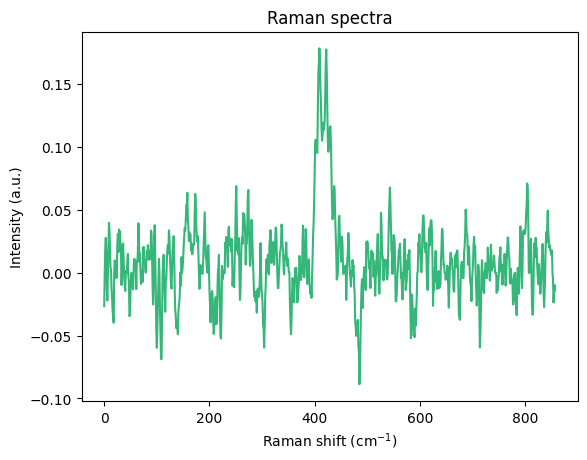

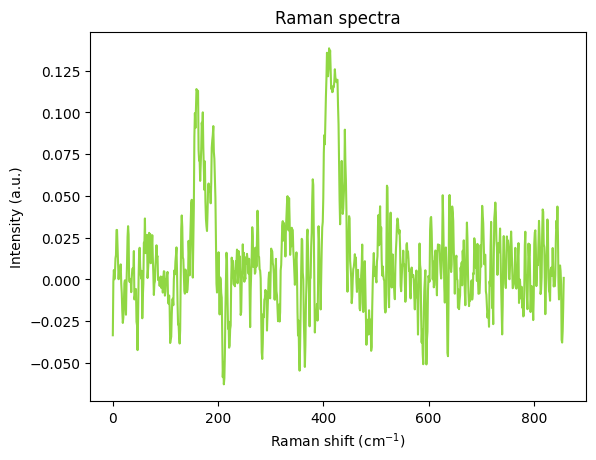

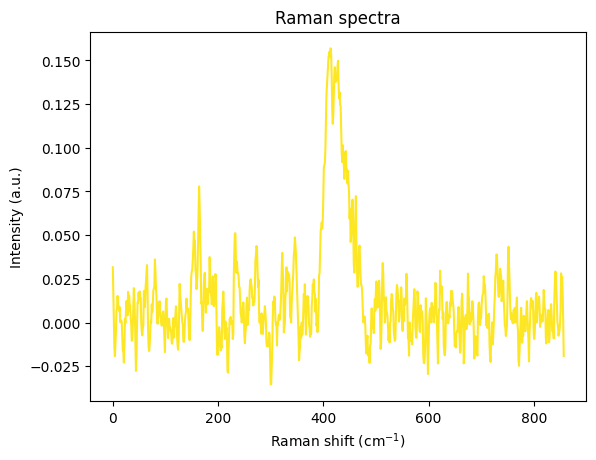

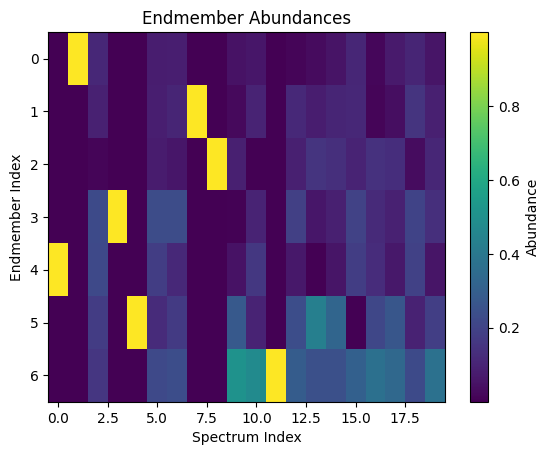

In [ ]:
import ramanspy as rp

wavenumbers = raman_df['wavenumber'].values
intensities = raman_df.drop('wavenumber', axis=1).values.T  # Transpose here!

# apply a preprocessing pipeline
pipeline = rp.preprocessing.Pipeline([
    # standard range used for Raman tissue
    rp.preprocessing.misc.Cropper(region=(700, 1800)), 
    
    # Removes sharp, unnatural spikes (caused by cosmic rays or electronic noise).
    rp.preprocessing.despike.WhitakerHayes(), 
    
    # (Savitzky-Golay Smoothing)
    # Smooths the spectrum to remove high-frequency noise, while preserving true peaks.
    # Fits a small polynomial (degree 3) across 7-point moving windows
    # Replaces each point with the fitted value
    # Keeps real molecular peaks (sharp, consistent)
    # Removes tiny jittery bumps from detectors
    rp.preprocessing.denoise.SavGol(window_length=7, polyorder=3),
    
    # Adaptive Smoothing Penalized Least Squares (Baseline Correction)
    # Removes the background curve (baseline), usually caused by tissue fluorescence.
    # Biological tissue often fluoresces under laser → adds a sloping background
    # Without correction, your peaks look smaller than they are, or even disappear
    # Preserving small peaks
    rp.preprocessing.baseline.ASPLS(),
    
    # (Vector Normalization)
    # Normalizes the spectrum to a common scale (0-1)
    # Ensures that the intensity of each spectrum is comparable
    # Vector normalization preserves peak shape and relative heights, which is important for ML models like SVM or CNN.
    rp.preprocessing.normalise.Vector(),
])
spectra = rp.SpectralContainer(intensities, wavenumbers)
data = pipeline.apply(spectra)

# perform spectral unmixing
# Note: The N-FINDR algorithm is sensitive to the number of endmembers specified.
# The number of endmembers should be less than or equal to the number of spectra.
# Abundance method: 
# "fcls" (Fuzzy C-Means) is used to estimate the abundance of each endmember in each pixel.
# "ucls" (Unscented Kalman Filter) is used to estimate the abundance of each endmember in each pixel.
# "nnls" (Non-negative Least Squares) is used to estimate the abundance of each endmember in each pixel.
nfindr = rp.analysis.unmix.NFINDR(n_endmembers=7, abundance_method="fcls")
# apply the unmixing algorithm
# amaps: abundance maps
# endmembers: endmember spectra
amaps, endmembers = nfindr.apply(data)

console_log(rawdata_dir)
# plot results
rp.plot.spectra(endmembers)
# rp.plot.image(amaps) # Remove this

# Optional: Visualize abundances as a heatmap
plt.figure()
plt.imshow(amaps, aspect='auto', cmap='viridis')
plt.colorbar(label='Abundance')
plt.xlabel('Spectrum Index')
plt.ylabel('Endmember Index')
plt.title('Endmember Abundances')

rp.plot.show()

/mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/Tamura/引き継ぎ/ヒルシュ/データ/merged_data_raw/Case2/hirsch/hirsch.csv


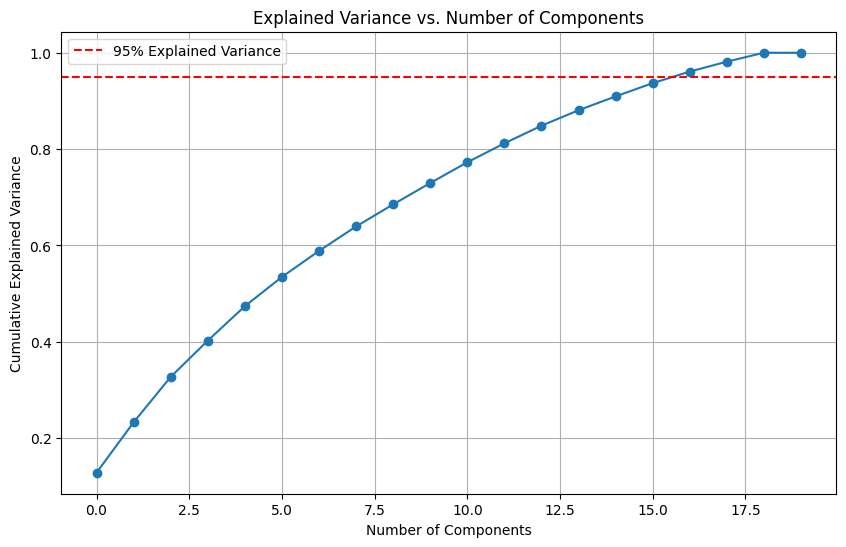

Number of components needed for 95.0% variance: 17

Cluster labels assigned by k-means: [1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0]


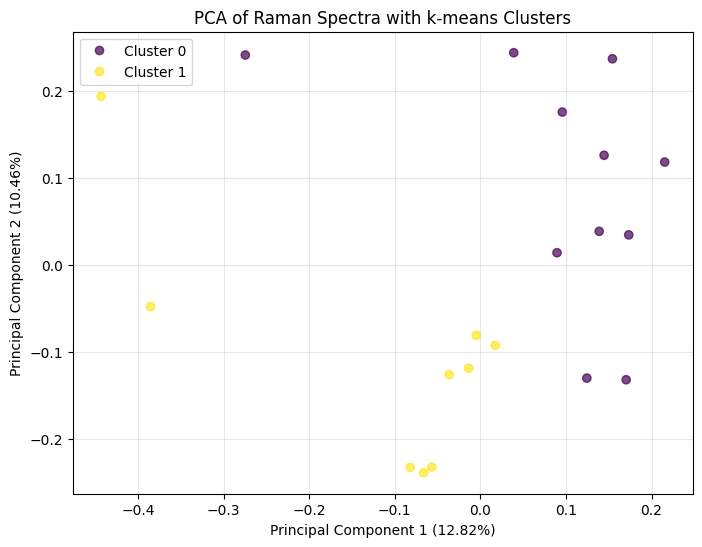

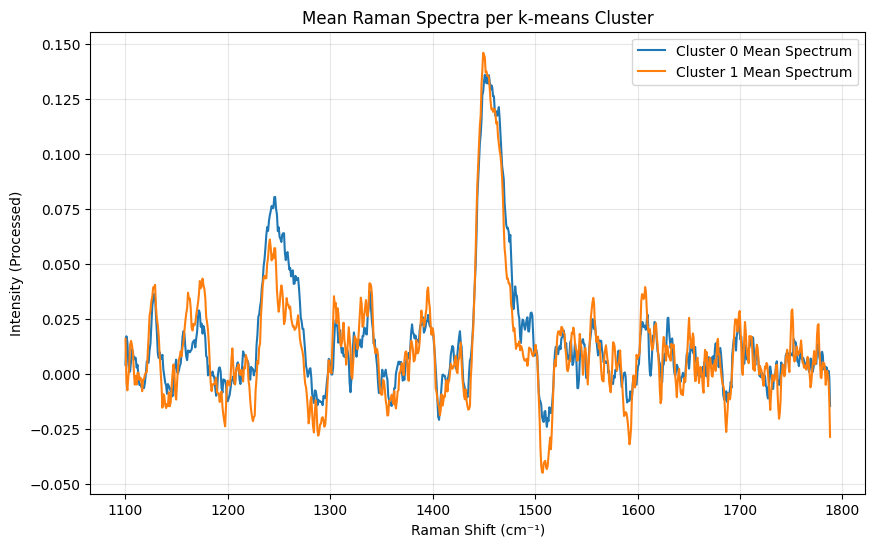

In [34]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

console_log(rawdata_dir)
# Ensure 'data' is your preprocessed SpectralContainer from ramanspy
# The spectral data is stored in data.spectral_data (shape: n_samples, n_wavenumbers)
spectral_data_matrix = data.spectral_data

# 1. Apply PCA
# PCA (Principal Component Analysis) is a technique to reduce the dimensionality of the data
# Determine optimal number of components using explained variance
pca_full = PCA().fit(spectral_data_matrix)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), 'o-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()

# 2. Choose components to reach 95% explained variance
variance_threshold = 0.95
n_components_95 = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= variance_threshold) + 1
console_log(f"Number of components needed for {variance_threshold*100}% variance: {n_components_95}")

# 3. Apply PCA with this optimal number
pca_optimal = PCA(n_components=n_components_95)
pca_result_optimal = pca_optimal.fit_transform(spectral_data_matrix)

# 4. Apply k-means on the optimal PCA results
n_clusters = 2  # Define number of clusters as a variable
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(pca_result_optimal)

console_log(f"\nCluster labels assigned by k-means: {cluster_labels}")

# 5. Create a 2D PCA for visualization purposes only
pca_viz = PCA(n_components=2).fit(spectral_data_matrix)
pca_result_viz = pca_viz.transform(spectral_data_matrix)

# 6. Visualize the clusters in 2D PCA space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result_viz[:, 0], pca_result_viz[:, 1], 
                     c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('PCA of Raman Spectra with k-means Clusters')
plt.xlabel(f'Principal Component 1 ({pca_viz.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca_viz.explained_variance_ratio_[1]*100:.2f}%)')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(n_clusters)])
plt.grid(True, alpha=0.3)
plt.show()

# 7. Analyze cluster characteristics (e.g., plot mean spectra per cluster)
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_spectra = spectral_data_matrix[cluster_labels == i]
    mean_spectrum = cluster_spectra.mean(axis=0)
    plt.plot(data.spectral_axis, mean_spectrum, label=f'Cluster {i} Mean Spectrum')

plt.title('Mean Raman Spectra per k-means Cluster')
plt.xlabel('Raman Shift (cm⁻¹)')
plt.ylabel('Intensity (Processed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()